C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

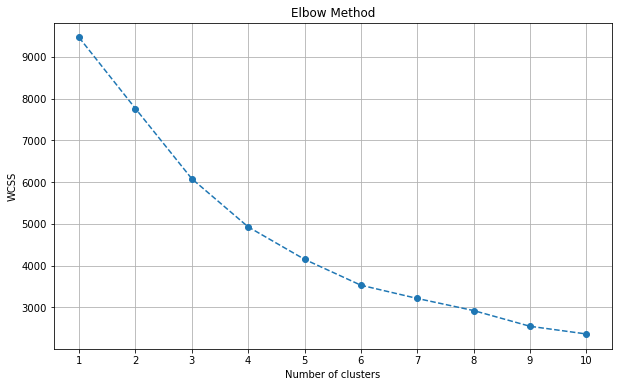

In [36]:
import cv2
import numpy as np
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm


## FEATURE-EXTRACTION - METHOD-1
def find_blob_properties(image_path):
    # Read the image
    image = cv2.imread(image_path)
    blob_properties = []

    # applying some filters before drawing contours
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (3, 3), .8)
    edges = cv2.Canny(blurred, 8, 50)
    
    
    _, binary_image = cv2.threshold(edges, 200, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.002* cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) < 3:
            continue

        sides = len(approx)
        
        contour_area = cv2.contourArea(contour)
        
        x, y, w, h = cv2.boundingRect(approx)
        bounding_box_area = w * h
        perimeter = cv2.arcLength(contour, True)
        # Calculate circularity
        circularity = (4 * np.pi * contour_area) / (perimeter ** 2)
        
        # Calculate convex hull and its area
        convex_hull = cv2.convexHull(contour)
        convex_hull_area = cv2.contourArea(convex_hull)
        
        # Calculate solidity
        solidity = contour_area / convex_hull_area
        
        # Calculate moments
        moments = cv2.moments(contour)
        
        # Calculate Hu Moments
        hu_moments = cv2.HuMoments(moments)
        # Convert Hu Moments to a more human-readable format
        hu_moments = [-1 * np.sign(h) * np.log10(abs(h)) if h != 0 else 0 for h in hu_moments]

        # Drawing the image with contour
        cv2.drawContours(image, [approx], 0, (155, 155, 0), 2)
        cv2.putText(image, str(sides), tuple(approx[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.rectangle(image, (x, y), (x + w, y+h), (0, 255, 0), 2)

        # cv2.startWindowThread()
        # cv2.imshow('Polygons with Sides Count', image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        
        blob_properties.append({ "num_vertices": sides, "bounding_box": (x, y, w, h), "contour_area": contour_area, "bounding_box_area": bounding_box_area, 
                                "circularity": circularity, "solidity": solidity})    
    return image, blob_properties
        
    

## METHOD-1 :: K-means using basic geometric features
def cluster_indices_kmeans(data):

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # Elbow Method to find optimal number of clusters
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Plotting the Elbow Method graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.xticks(np.arange(1, 11, 1))
    plt.grid(True)
    plt.show()

df = None
    
def main():
    global df
    folder_path = "E7-images"
    image_files = os.listdir(folder_path)
    features_method_1 = {"num_vertices" : [], "x": [], "y": [], "w" : [], "h" :[], "c_area" : [], "solidity" :[], "circularity": []}  # dictionary that has all details about the images
    features_method_2 = []
    
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        
        ## METHOD-1 Features
        image_with_blobs, blob_properties = find_blob_properties(image_path)   # Find blob properties and draw them on the image
        features_method_1["num_vertices"].append(blob_properties[0]["num_vertices"])
        features_method_1["x"].append(blob_properties[0]["bounding_box"][0])
        features_method_1["y"].append(blob_properties[0]["bounding_box"][1])
        features_method_1["w"].append(blob_properties[0]["bounding_box"][2])
        features_method_1["h"].append(blob_properties[0]["bounding_box"][3])
        features_method_1["c_area"].append(blob_properties[0]["contour_area"])
        features_method_1["solidity"].append(blob_properties[0]["solidity"])
        features_method_1["circularity"].append(blob_properties[0]["circularity"])
        
        
        
    df = pd.DataFrame(features_method_1)
    cluster_indices_kmeans(df)
    

    
if __name__ == "__main__":
    main()


In [37]:
print(df)

      num_vertices    x   y    w    h    c_area  solidity  circularity
0                6  102  73  452  339  134731.5  0.945604     0.690835
1                9  102  73  452  338  130780.5  0.977177     0.724908
2               20  102  73  452  338  107663.5  0.933878     0.686581
3               14  102  74  452  337  101004.0  0.902490     0.598691
4                5  101  74  454  338  146805.5  0.994186     0.766928
...            ...  ...  ..  ...  ...       ...       ...          ...
1178            21  102  74  453  336  115441.5  0.938373     0.589889
1179             3  102  74  452  337   76794.0  0.992908     0.507339
1180            19  101  74  453  337  105909.0  0.970449     0.725765
1181             8  101  73  454  339  147651.5  0.995292     0.792612
1182             7  101  74  453  338   94400.5  0.913892     0.590061

[1183 rows x 8 columns]


In [38]:
import pandas as pd

# Assuming your DataFrame is named df

# Calculate bounding box area
df['bounding_box_area'] = df['w'] * df['h']

# Calculate c_area/b_area ratio
df['c_area/b_area'] = df['c_area'] / df['bounding_box_area']

# Print or display the DataFrame to check the changes
print(df)

      num_vertices    x   y    w    h    c_area  solidity  circularity  \
0                6  102  73  452  339  134731.5  0.945604     0.690835   
1                9  102  73  452  338  130780.5  0.977177     0.724908   
2               20  102  73  452  338  107663.5  0.933878     0.686581   
3               14  102  74  452  337  101004.0  0.902490     0.598691   
4                5  101  74  454  338  146805.5  0.994186     0.766928   
...            ...  ...  ..  ...  ...       ...       ...          ...   
1178            21  102  74  453  336  115441.5  0.938373     0.589889   
1179             3  102  74  452  337   76794.0  0.992908     0.507339   
1180            19  101  74  453  337  105909.0  0.970449     0.725765   
1181             8  101  73  454  339  147651.5  0.995292     0.792612   
1182             7  101  74  453  338   94400.5  0.913892     0.590061   

      bounding_box_area  c_area/b_area  
0                153228       0.879288  
1                152776      

In [39]:
df

,num_vertices,x,y,w,h,c_area,solidity,circularity,bounding_box_area,c_area/b_area
0,6,102,73,452,339,134731.5,0.945604,0.690835,153228,0.879288
1,9,102,73,452,338,130780.5,0.977177,0.724908,152776,0.856028
2,20,102,73,452,338,107663.5,0.933878,0.686581,152776,0.704715
3,14,102,74,452,337,101004.0,0.902490,0.598691,152324,0.663087
4,5,101,74,454,338,146805.5,0.994186,0.766928,153452,0.956687
...,...,...,...,...,...,...,...,...,...,...
1178,21,102,74,453,336,115441.5,0.938373,0.589889,152208,0.758446
1179,3,102,74,452,337,76794.0,0.992908,0.507339,152324,0.504149
1180,19,101,74,453,337,105909.0,0.970449,0.725765,152661,0.693753
1181,8,101,73,454,339,147651.5,0.995292,0.792612,153906,0.959362


In [21]:
df.to_csv('your_file_name.csv', index=False)

In [40]:
def classify_complexity(row):
    if row['num_vertices'] < mid_threshold and row['c_area/b_area'] > low_c_area_ratio_threshold or row['num_vertices'] == 3:
        return 'Low Complexity'
    elif row['num_vertices'] > high_threshold:
        return 'High Complexity'
    else:
        return 'Medium Complexity'

# Define thresholds (you need to define appropriate thresholds)
mid_threshold = 10
high_threshold = 15
low_c_area_ratio_threshold = 0.85

# Apply classification logic
df['complexity'] = df.apply(classify_complexity, axis=1)

# Print or display the DataFrame with complexity labels
print(df)


      num_vertices    x   y    w    h    c_area  solidity  circularity  \
0                6  102  73  452  339  134731.5  0.945604     0.690835   
1                9  102  73  452  338  130780.5  0.977177     0.724908   
2               20  102  73  452  338  107663.5  0.933878     0.686581   
3               14  102  74  452  337  101004.0  0.902490     0.598691   
4                5  101  74  454  338  146805.5  0.994186     0.766928   
...            ...  ...  ..  ...  ...       ...       ...          ...   
1178            21  102  74  453  336  115441.5  0.938373     0.589889   
1179             3  102  74  452  337   76794.0  0.992908     0.507339   
1180            19  101  74  453  337  105909.0  0.970449     0.725765   
1181             8  101  73  454  339  147651.5  0.995292     0.792612   
1182             7  101  74  453  338   94400.5  0.913892     0.590061   

      bounding_box_area  c_area/b_area         complexity  
0                153228       0.879288     Low Comp

In [41]:
df.to_csv('df3.csv', index=False)